<a href="https://colab.research.google.com/github/sarenales/MDD/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este ejemplo ha sido adaptado desde los materiales encontrados en la web de Sebastian Raschka: https://sebastianraschka.com/Articles/2014_pca_step_by_step.html

# Generando datos de ejemplo en 3D
Para este ejemplo vamos a generar 40 muestras escogidas aleatoriamente desde una distribución Gaussiana. Las muestras se dividen en dos clases C1 y C2. El 50% es de C1 y el otro 50% de C2.





In [ ]:
import numpy as np

np.random.seed(7) # random seed for consistency

mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
assert class1_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
assert class2_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

Con el código de arriba hemos generado dos datasets de 3 x 20 - uno para cada clase. Cada columna de nuestra matriz es una muestra de 3 dimensiones, mientras que las tres líneas representan a las variables predictoras. Vamos a ver en una gráfica cómo se distribuyen las muestras segun su clase.

Populating the interactive namespace from numpy and matplotlib


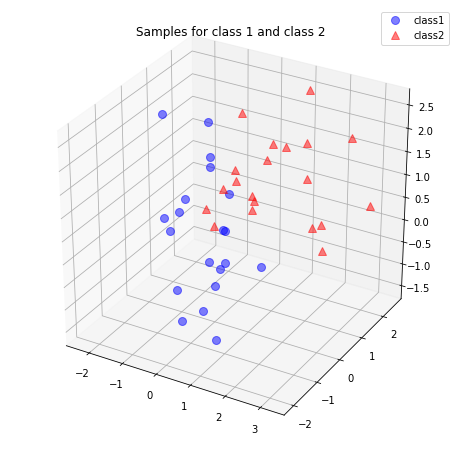

In [ ]:
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

Ahora vamos a construir un único dataset a partir de los dos datasets generados, ignorando la clase:

In [ ]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
assert all_samples.shape == (3,40), "The matrix has not the dimensions 3x40"

# Los pasos para calcular el PCA
Siguiendo los pasos para el PCA, calcularemos la **matriz de covarianza**, usando la función que nos ofrece Numpy:

In [ ]:
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])
print('Covariance Matrix:\n', cov_mat)

Covariance Matrix:
 [[1.33604162 0.21546098 0.1358902 ]
 [0.21546098 1.47863453 0.32668112]
 [0.1358902  0.32668112 1.16718576]]


Para calcular los **vectores y valores propios**, también usaremos una función de Numpy:

In [ ]:
# eigenvectors and eigenvalues from the covariance matrix
eig_val, eig_vec = np.linalg.eig(cov_mat)
print("eig vec shape: {}".format(eig_vec[0].shape))

eig vec shape: (3,)


Vamos a visualizar ahora los vectores y valores propios:

Populating the interactive namespace from numpy and matplotlib


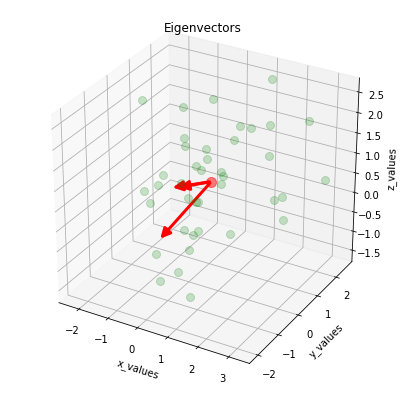

In [ ]:
%pylab inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
# Calculate the mean in x, y and z
mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

Como nuestro objetivo es reducir el número de dimensiones, vamos a ordenar los vectores propios segun los valores propios asociados (en orden descendente):

In [ ]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

1.8191309176600436
1.2017195259967013
0.9610114635048719


En nuestro ejemplo, donde queremos reducir de 3 a 2 dimensiones, vamos a quedarnos con los dos primeros vectores propios y construiremos nuestra matriz W de tamaño d x k (3x2).

In [ ]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.46642995 -0.8845581 ]
 [-0.74806213  0.3942924 ]
 [-0.47206583  0.24917961]]


Solo nos queda **proyectar** nuestras muestras originales al nuevo espacio de menor dimensionalidad. Para ello usaremos la matriz W:

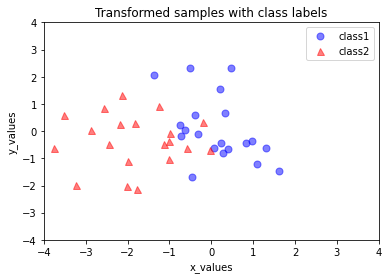

In [ ]:
transformed = matrix_w.T.dot(all_samples)
assert transformed.shape == (2,40), "The matrix is not 2x40 dimensional."
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()